In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import segyio
import gstools as gs
import os
import lasio

In [2]:
from scipy.interpolate import interp1d, interp2d
from scipy.interpolate import griddata, RegularGridInterpolator, LinearNDInterpolator

In [3]:
import numpy as np
from scipy.ndimage import map_coordinates
from scipy import signal
from scipy.interpolate import interp1d
import gstools as gs
from scipy.interpolate import RectBivariateSpline

def find_normalized_thickness(surfs, loc):
    """
    Compute the normalized cumulative thickness between surfaces.
    Parameters
    ----------
    surfs : list of ndarray
        List of 2D arrays representing surfaces.
    loc : tuple of int
        Location in inline and crossline indices (i_il, i_xl).
    Returns
    -------
    ndarray
        Cumulative normalized thickness.
    """
    i_il, i_xl = loc
    thick = np.zeros(len(surfs))
    for i in range(1, len(surfs)):
        thick[i] = abs(surfs[i][i_il, i_xl] - surfs[i - 1][i_il, i_xl])
    thick = abs(thick) / np.sum(thick)
    return np.cumsum(thick)

def deflat(cube, ijk, silence=True):
    """
    Deflat a data cube using precomputed indices.
    Parameters
    ----------
    cube : ndarray
        3D seismic data array (il,xl,nsamples).
    ijk : ndarray
        3D index map for deflattening (il,xl,nsamples).
    silence : bool, optional
        If True, suppress progress messages. Default is True.
    Returns
    -------
    ndarray
        Deflattened cube.
    """
    new_cube = np.empty_like(ijk)
    for i in range(cube.shape[0]):
        cube_cut = cube[i].T.copy()
        ijk_cut = ijk[i].T.copy()
        _, x = np.indices(ijk_cut.shape)
        y = ijk_cut * (cube.shape[2] - 1)
        y[:, -1] = y[:, -2]
        deformed = map_coordinates(cube_cut, (y, x))
        new_cube[i] = deformed.T
        if not silence:
            print(f"Deflattening Inline Index [{i}] {((i + 1)/ cube.shape[0]) * 100:.2f}%\r", end="")
    return new_cube

def low_pass(cube, cut_hz_vert, dt_s, cut_hz_hor=15, silence=True):
    """
    Apply a low-pass filter to a data cube.
    Parameters
    ----------
    cube : ndarray
        3D seismic data array (il,xl,nsamples).
    cut_hz : float
        Cut-off frequency in Hz.
    dt_s : float
        Sampling interval in seconds.
    silence : bool, optional
        If True, suppress progress messages. Default is True.
    Returns
    -------
    ndarray
        Filtered seismic cube.
    """
    nfilt = 1
    samplerate_hz = 1 / dt_s
    nyquist = samplerate_hz / 2
    b, a = signal.butter(nfilt, cut_hz_vert / nyquist, btype='lowpass')
    b2, a2 = signal.butter(nfilt, cut_hz_hor / nyquist, btype='lowpass')
    new_cube = np.empty_like(cube)
    for i in range(cube.shape[0]):
        new_cube[i, :, :] = signal.filtfilt(b, a, cube[i, :, :], axis=0)
        new_cube[i, :, :] = signal.filtfilt(b2, a2, cube[i, :, :], axis=1)
        if not silence:
            print(f"Filtering Inline Index [{i}] {((i + 1)/ cube.shape[0]) * 100:.2f}%\r", end="")
    for j in range(cube.shape[1]):
        new_cube[:, j, :] = signal.filtfilt(b2, a2, cube[:, j, :], axis=1)
        if not silence:
            print(f"Filtering Crossline Index [{j}] {((j + 1)/ cube.shape[1]) * 100:.2f}%\r", end="")
    return new_cube

class BMTools:
    """
    Class for handling a full background modeling workflow.
    """
    def __init__(self):
        """Initialize BMTools with default attributes."""
        self.logs = None            # Well logs
        self.pos = None             # Relative well locations
        self.seismic_shape = None   # Shape of the seismic cube
        self.rgt_thick = None       # Relative Geological Time thickness
        self.rgt = None             # RGT cube
        self.logs_flat = None       # Flattened logs
        self.krig_flat = None            # Kriging results
        self.krig = None        # Deformed cube
        self.time = None            # Time vector
        self.dt = None              # Time sampling interval
        self.dt_s = None            # Time sampling in seconds
        self.rgt_ref = None         # Reference RGT trace
        self.model = None        # Low-pass filtered data (background model)

    def build_rgt(self, surfaces, time, silence=True, ref_trace=None):
        """
        Build Relative Geological Time (RGT) volume.
        Parameters
        ----------
        surfaces : ndarray
            3D array of interpreted surfaces (il,xl,nsamples).
        time : ndarray
            1D array of time values in milliseconds (nsamples).
        silence : bool, optional
            If True, suppress progress messages. Default is True.
        Returns
        -------
        BMTools
            Self instance with updated RGT attributes.
        """
        self.seismic_shape = np.asarray((surfaces.shape[1], surfaces.shape[2], len(time)))
        if not ref_trace:
            ref_trace = (self.seismic_shape[0]//2, self.seismic_shape[1]//2)
        self.rgt_thick = find_normalized_thickness(surfaces, ref_trace)
        self.rgt = np.full(self.seismic_shape, np.nan)
        self.time = time.copy()
        self.dt = self.time[1] - self.time[0]
        self.dt_s = self.dt / 1000
        nlayers = len(surfaces) - 1

        for i in range(self.seismic_shape[0]):
            for j in range(self.seismic_shape[1]):
                for k in range(nlayers):
                    mask = np.arange(
                        (surfaces[k][i, j] - self.time[0]) // self.dt,
                        (surfaces[k + 1][i, j] - self.time[0]) // self.dt
                    ).astype(int)
                    self.rgt[i, j, mask] = np.linspace(self.rgt_thick[k], self.rgt_thick[k + 1], len(mask))
                self.rgt[i, j, :np.nanargmin(self.rgt[i, j])] = 0
                self.rgt[i, j, np.nanargmax(self.rgt[i, j]):] = 1
            if not silence:
                print(f"Building RGT Model Inline Index [{i}] ({((i + 1)/ self.seismic_shape[0]) * 100:.2f})%\r", end="")
        return self

    def read_wells(self, well_logs, relative_well_loc, rgt_domain_length=500):
        """
        Process well logs and map to RGT.
        Parameters
        ----------
        well_logs : ndarray
            2D array of well logs (nwells, nsamples).
        relative_well_loc : ndarray
            2D array of well locations (index of inline, index of crossline).
        Returns
        -------
        BMTools
            Self instance with updated well log attributes.
        """
        self.logs_z = well_logs
        self.pos = relative_well_loc.T
        self.logs_flat = np.empty((self.logs_z.shape[0], rgt_domain_length))
        self.rgt_ref = np.linspace(0,1,rgt_domain_length)

        for i in range(self.logs_flat.shape[0]):
            il_index, xl_index = self.pos
            index_rgt = self.rgt[il_index[i], xl_index[i], :].copy()
            index_rgt[:np.nanargmin(index_rgt)] = 0
            index_rgt[np.nanargmax(index_rgt) + 1:] = 1
            interpolator = interp1d(index_rgt, self.logs_z[i], fill_value=np.nan, kind="linear")
            self.logs_flat[i, :] = interpolator(self.rgt_ref)
        return self

    def interpol(self, variogram, well_logs, relative_well_loc, fill_value, skip_values=0, second_var=None, silence=True, decimate=0, rgt_domain_length=500):
        """
        Perform kriging, deflattening and low-pass filter.
        Parameters
        ----------
        variogram : gstools.Variogram
            Variogram (gsstools) model for kriging.
        cut_hz : float
            Cut-off frequency in Hz for low-pass filtering.
        fill_value : tuple of float
            Values to fill in top and base regions.
        silence : bool, optional
            If True, suppress progress messages. Default is True.
        Returns
        -------
        BMTools
            Self instance with updated attributes.
        """
        self.read_wells(well_logs, relative_well_loc, rgt_domain_length)
        self.rgt_ref = np.linspace(0, 1, rgt_domain_length)
        self.krig_flat = np.zeros((self.rgt.shape[0], self.rgt.shape[1], rgt_domain_length))
        self.krig = np.zeros_like(self.rgt)
        gridy = np.arange(self.seismic_shape[0], dtype=np.float32)
        gridx = np.arange(self.seismic_shape[1], dtype=np.float32)
        x, y = (self.pos[1], self.pos[0])
        top, base = True, False
        if decimate>0:
            gridx_dec = gridx.copy()[::decimate]
            gridy_dec = gridy.copy()[::decimate]

        for i in range(self.rgt_ref.shape[0]):
            if self.rgt_ref[i] == 0:
                self.krig_flat[:, :, i] = fill_value[0]
            elif self.rgt_ref[i] == 1:
                self.krig_flat[:, :, i] = fill_value[1]
            else:
                dvals = self.logs_flat[:, i].copy()
                #dvals[dvals==skip_values] = np.nan
                if np.sum(~np.isnan(dvals)) > 0:
                    OK = gs.krige.ExtDrift(variogram, (x, y), dvals, ext_drift = second_var[self.pos[0][~np.isnan(dvals)],
                                                                                            self.pos[1][~np.isnan(dvals)],
                                                                                            i])
                    if decimate<=0:
                        self.krig_flat[:, :, i] = OK.structured([gridx, gridy], ext_drift=second_var[:,:,i])[0].T
                    else:
                        krig_dec = OK.structured([gridx_dec, gridy_dec], ext_drift=second_var[::decimate,::decimate,i])[0]
                        interpol = RectBivariateSpline(gridx_dec, gridy_dec, krig_dec)
                        OK_structured = interpol(gridx, gridy)
                        self.krig_flat[:, :, i] = OK_structured.T
                    top, base = False, True
                elif top:
                    self.krig_flat[:, :, i] = fill_value[0]
                elif base:
                    self.krig_flat[:, :, i] = fill_value[1]
            if not silence:
                print(f"Kriging Index [{i}] ({((i + 1) / self.seismic_shape[2]) * 100:.2f}%) done\r", end="")
        self.krig = deflat(self.krig_flat, self.rgt, silence)
        return self

    def smooth_model(self, cut_hz_vert, cut_hz_hor=15, silence=True):
        self.model = low_pass(self.krig, cut_hz_vert, self.dt_s, cut_hz_hor, silence)
        return self

In [ ]:
mymodel.pos

array([[ 946, 1215, 1048,  768, 1146,  734,  717, 1132,  935,  882, 1187,
         845, 1175, 1294, 1018,  899],
       [ 654,  591,  947, 1620, 1767, 1427,  828, 1332,  737,  744,  938,
        1022, 1060, 1067, 1024, 1275]])

In [ ]:
#Loading seismic using Segyio lib

# string containing the path location of the seismic data at disk
velocity_flat = np.load('/run/media/aalbano/ExtDrive/abl_data/Velocity_Model_Time_FLAT.npy' )

In [ ]:
seis = segyio.open(r'Velocity_Model_Time.sgy', iline=189, xline=193)
velocity = segyio.cube(seis)
velocity = velocity[:-1,:-1,425:1025]
velocity.shape

(2168, 2752, 600)

In [ ]:
import os

# Define o caminho para a pasta contendo os arquivos LAS
pasta_las = 'data/Wells/'

# Dicionário para armazenar os valores de skiprows para cada poço
skiprows_pocos = {}

# Loop pelos arquivos LAS na pasta para encontrar skiprows
for arquivo in os.listdir(pasta_las):
    if arquivo.endswith('.las'):
        nome_poco = arquivo.split('.')[0]

        with open(os.path.join(pasta_las, arquivo), 'r') as f:
            for i, line in enumerate(f):
                if '~	DEPTH' in line:  # Substitua '~A' pela linha que indica o início dos dados
                    skiprows_pocos[nome_poco] = i + 1
                    break
            else:
                skiprows_pocos[nome_poco] = 0  # Valor padrão se a linha não for encontrada

# Cria um dicionário para armazenar os DataFrames de cada poço
dados_pocos = {}

# Loop pelos arquivos LAS na pasta para ler os dados
for arquivo in os.listdir(pasta_las):
    if arquivo.endswith('.las'):
        nome_poco = arquivo.split('.')[0]
        skiprows = skiprows_pocos[nome_poco]  # Obtém o skiprows do dicionário

        # Lê o arquivo LAS e define os nomes das colunas
        names = pd.read_csv(os.path.join(pasta_las, arquivo), sep='\s+', skiprows=skiprows - 1, nrows=0)
        names = names.columns[1:]

        # Lê o arquivo LAS com os dados
        print(nome_poco)
        df = pd.read_csv(os.path.join(pasta_las, arquivo), sep='\s+', skiprows=skiprows, na_values=-9999,
                         usecols=np.arange(len(names)), names=names)

        # Check if 'VP' column exists before calculating 'IS'
        df['CALIR'] = np.nan
        if 'DTCO' in df.columns:
            df['VP'] = 304800 / df['DTCO']
            df['IP'] = df['VP']*df['RHOB']

        else:
            # Handle the case where 'VP' is missing, e.g., set 'IS' to NaN
            df['VP'] = np.nan
            df['IP'] = np.nan

        # Check if 'VS' column exists before calculating 'IS'
        if 'DTS' in df.columns:
            df['VS'] = 304800 / df['DTS']
            df['IS'] = df['VS'] * df['RHOB']
        else:
            # Handle the case where 'VS' is missing, e.g., set 'IS' to NaN
            df['IS'] = np.nan


        # Adiciona uma coluna com o nome do poço
        df['Well'] = nome_poco

        # Armazena o DataFrame no dicionário
        dados_pocos[nome_poco] = df

# Concatena todos os DataFrames em um único DataFrame
df_final = pd.concat(dados_pocos.values(), ignore_index=True)

1-RJS-342-RJS
3-RJS-355-RJS
3-RJS-360A-RJS
3-RJS-510A-RJS
4-ABL-30A-RJS
4-RJS-367-RJS
4-RJS-477A-RJS
6-ABL-1-RJS
9-AB-67-RJS
9-AB-71-RJS
9-ABL-2-RJS
9-ABL-3B-RJS
9-ABL-5-RJS
9-ABL-6A-RJS
9-ABL-7-RJS
9-ABL-9D-RJS


In [ ]:
df_final = df_final[['Well','DEPTH','IP']]
df_final.head()

,Well,DEPTH,IP
0,1-RJS-342-RJS,953.0000,NaN
1,1-RJS-342-RJS,953.1524,NaN
2,1-RJS-342-RJS,953.3048,NaN
3,1-RJS-342-RJS,953.4572,NaN
4,1-RJS-342-RJS,953.6096,NaN


In [ ]:
len(df_final.Well.unique())

16

Importe a biblioteca do modelo de baixa

# Leitura de Exemplo

## Parâmetros

Vamos ler a sísmica apenas para saber o shape e a taxa de amostragem. Isso também podem pode ser inserido manualmente, sem a necessidade de ler o arquivo.

In [ ]:
#dt_ms = time[1] - time[0]
dt_ms = 4
dt_ms

4

## Horizontes

In [ ]:
surf_saltbase = np.load(os.path.join(r'E:/db-horizons/SaltBase_v1_TIME_grid.npy')).T
surf_intraalagoas = np.load(os.path.join(r'E:/db-horizons/IntraAlagoas_v0_TIME_grid.npy')).T
surf_prealagoas = np.load(os.path.join(r'E:/db-horizons/PreAlagoas_v1_TIME_grid.npy')).T
surf_intrajiquia = np.load(os.path.join(r'E:/db-horizons/IntraJiquia_v1_TIME_grid.npy')).T
surf_picarras = np.load(os.path.join(r'E:/db-horizons/PreJiquia_V0_TIME_grid.npy')).T

## Leitura

In [ ]:
hrz_ma = pd.read_csv('Horizontes/Time/Marco_Azul.txt', sep='\s+', usecols=(2,5,8), names=['IL','XL','TWT']).sort_values(by=['IL', 'XL'])
hrz_base140 = pd.read_csv('Horizontes/Time/140_Base.txt', sep='\s+', usecols=(2,5,8), names=['IL','XL','TWT']).sort_values(by=['IL', 'XL'])
hrz_mio = pd.read_csv('Horizontes/Time/Mioceno.txt', sep='\s+', usecols=(2,5,8), names=['IL','XL','TWT']).sort_values(by=['IL', "XL"])
hrz_ma

,IL,XL,TWT
5968504,172,756,3436.40674
5968505,172,757,3436.48169
5968506,172,758,3436.57104
5968507,172,759,3436.67090
5968508,172,760,3436.78027
...,...,...,...
2748,2340,3504,3712.59692
2749,2340,3505,3712.35376
2750,2340,3506,3712.12793
2751,2340,3507,3711.92310


## Grid

In [ ]:
il = np.arange(hrz_ma.IL.min(), hrz_ma.IL.max())
xl = np.arange(hrz_ma.XL.min(), hrz_ma.XL.max())
il, xl

(array([ 172,  173,  174, ..., 2337, 2338, 2339]),
 array([ 756,  757,  758, ..., 3505, 3506, 3507]))

In [ ]:
def grid_surface_as_seismic(df, il, xl):
    x, y, z = df[['IL', 'XL', 'TWT']].dropna().values.T
    # Eliminate any NaN
    valid_indices = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(z)
    x, y, z= x[valid_indices], y[valid_indices], z[valid_indices]
    # Create a meshgrid
    xx, yy = np.meshgrid(il, xl)
    # Reshape meshgrid into a (n_points, 2) array
    xi = np.column_stack((xx.ravel(), yy.ravel()))
    # Perform interpolation
    grid = griddata((x, y), z, xi, method='linear', fill_value=np.mean(z)).reshape(xx.shape)
    return grid.T

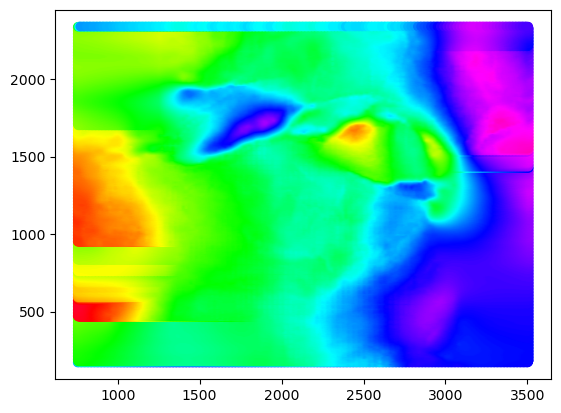

In [ ]:
plt.scatter(hrz_ma.XL.values[::20], hrz_ma.IL.values[::20], c=hrz_ma.TWT.values[::20], cmap='gist_rainbow')

In [ ]:
hrz_ma_grid = grid_surface_as_seismic(hrz_ma, il, xl)
hrz_ma_grid

array([[3436.40674, 3436.48169, 3436.57104, ..., 3636.92627, 3636.93799,
        3636.94922],
       [3434.6665 , 3434.73901, 3434.82349, ..., 3636.90747, 3636.91992,
        3636.93066],
       [3432.04126, 3432.11475, 3432.19873, ..., 3636.89502, 3636.90674,
        3636.91772],
       ...,
       [2893.57544, 2893.54858, 2893.51904, ..., 3711.49219, 3711.26831,
        3711.0625 ],
       [3118.08374, 3118.0564 , 3118.02563, ..., 3711.79932, 3711.5769 ,
        3711.37378],
       [3344.82983, 3344.80103, 3344.76782, ..., 3712.08667, 3711.86401,
        3711.66187]])

In [ ]:
hrz_base140_grid = grid_surface_as_seismic(hrz_base140, il, xl)
hrz_base140_grid.shape

(2168, 2752)

In [ ]:
hrz_mio_grid = grid_surface_as_seismic(hrz_mio, il, xl)
hrz_mio_grid.shape

(2168, 2752)

Observe que shape dos horizontes devem estar no mesmo da sísmica, ou seja: (iline,xlines)

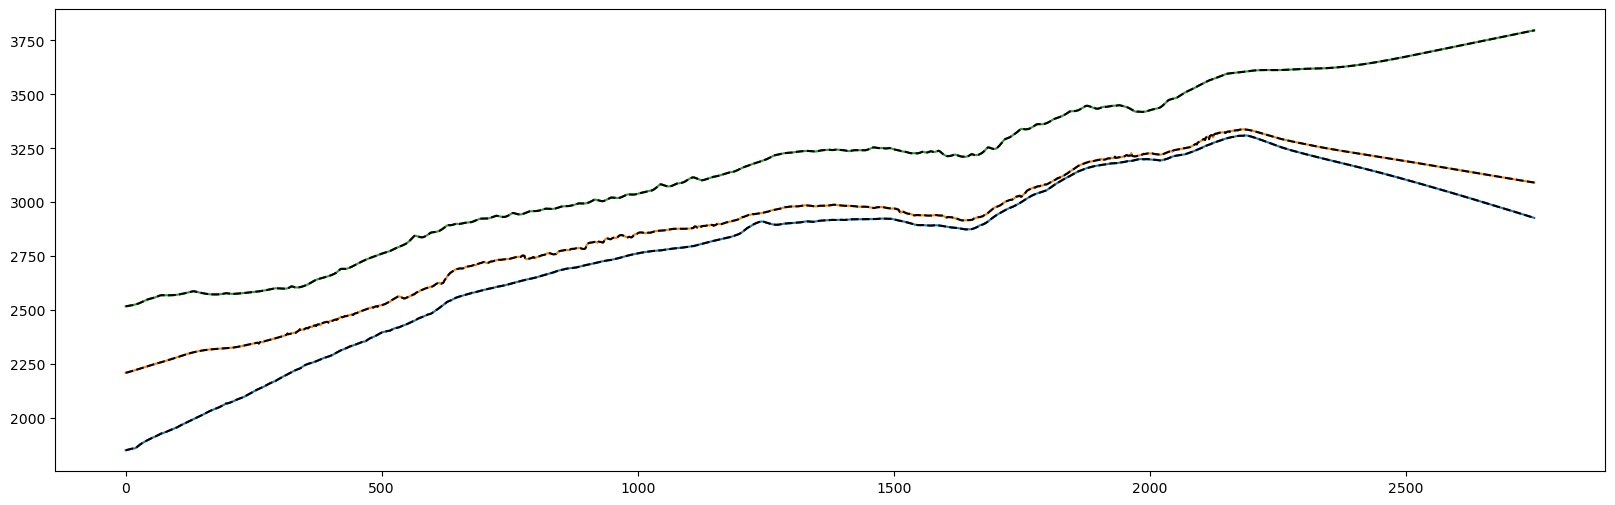

In [ ]:
plt.figure(figsize=(20, 6))

plt.plot(hrz_mio_grid[813].T)
plt.plot(hrz_base140_grid[813].T)
plt.plot(hrz_ma_grid[813].T)

plt.plot(hrz_mio.query('IL == 985').TWT.values, 'k--')
plt.plot(hrz_ma.query('IL == 985').TWT.values, 'k--')
plt.plot(hrz_base140.query('IL == 985').TWT.values, 'k--')


## Perfis

## Ler TDR

In [ ]:
df_final['TWT'] = np.nan
df_final['TVDSS'] = df_final['DEPTH'] - 26.5
for file in os.listdir('TDR/'):
    dfi = lasio.read(os.path.join('TDR/',file)).df().reset_index()
    wellname = file.replace('_TDR','-RJS')
    interpolador = interp1d(dfi['TVDSS'], dfi['ETIM'], fill_value='extrapolate', bounds_error=False)
    mask = (df_final.Well == wellname)
    df_final.loc[mask, 'TWT'] = interpolador(df_final[mask].TVDSS)
    print(file, dfi.columns, wellname)

1-RJS-342_TDR Index(['TVDSS', 'ETIM'], dtype='object') 1-RJS-342-RJS
3-RJS-355_TDR Index(['TVDSS', 'ETIM'], dtype='object') 3-RJS-355-RJS
3-RJS-360A_TDR Index(['TVDSS', 'ETIM'], dtype='object') 3-RJS-360A-RJS
3-RJS-510A_TDR Index(['TVDSS', 'ETIM'], dtype='object') 3-RJS-510A-RJS
4-ABL-30A_TDR Index(['TVDSS', 'ETIM'], dtype='object') 4-ABL-30A-RJS
4-RJS-367_TDR Index(['TVDSS', 'ETIM'], dtype='object') 4-RJS-367-RJS
4-RJS-477A_TDR Index(['TVDSS', 'ETIM'], dtype='object') 4-RJS-477A-RJS
6-ABL-1_TDR Index(['TVDSS', 'ETIM'], dtype='object') 6-ABL-1-RJS
9-AB-67_TDR Index(['TVDSS', 'ETIM'], dtype='object') 9-AB-67-RJS
9-AB-71_TDR Index(['TVDSS', 'ETIM'], dtype='object') 9-AB-71-RJS
9-ABL-2_TDR Index(['TVDSS', 'ETIM'], dtype='object') 9-ABL-2-RJS
9-ABL-3B_TDR Index(['TVDSS', 'ETIM'], dtype='object') 9-ABL-3B-RJS
9-ABL-5_TDR Index(['TVDSS', 'ETIM'], dtype='object') 9-ABL-5-RJS
9-ABL-6A_TDR Index(['TVDSS', 'ETIM'], dtype='object') 9-ABL-6A-RJS
9-ABL-7_TDR Index(['TVDSS', 'ETIM'], dtype='object')

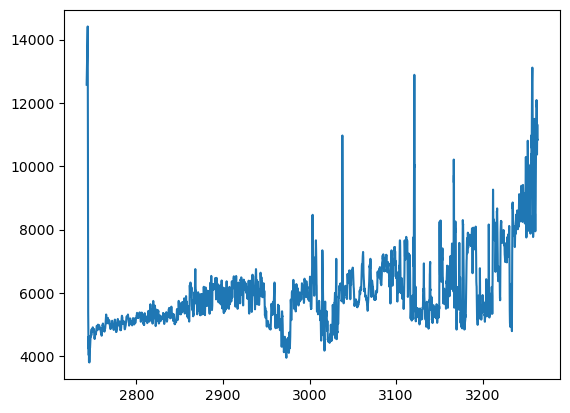

In [ ]:
plt.plot(df_final[mask].TWT, df_final[mask].IP)

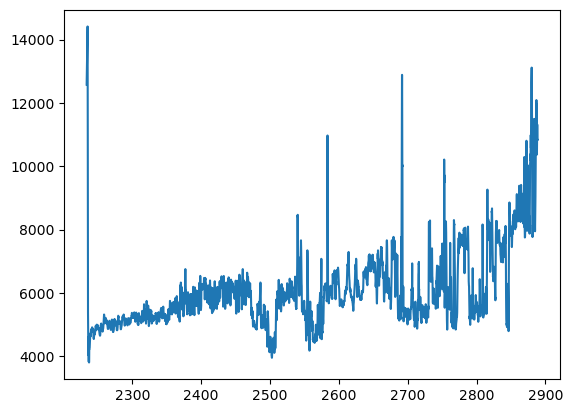

In [ ]:
plt.plot(df_final[mask].TVDSS, df_final[mask].IP)

## Reamostrar para 4ms

Considere uma matriz com os poços empilhados um por linha contendo a mesmo tamanho e amostrado na mesma dimensão do modelo, ou seja: (nwells,nsamples)

In [ ]:
time = np.arange(1700,4100,4)
len(df_final.Well.unique()), len(time)

(16, 600)

In [ ]:
log_well = np.zeros((16,600))
i = 0
df_final['IP_ups'] = df_final['IP']
for well in df_final.Well.unique():
    mask = (df_final.Well == well)
    df_final.loc[mask,'IP_ups'] = np.convolve(np.ones(30)/30, df_final[mask].IP, mode='same')
    interpolador = interp1d(df_final[mask].TWT, df_final[mask].IP_ups, bounds_error=False, fill_value='extrapolate')
    log_well[i,:] = interpolador(time)
    i += 1

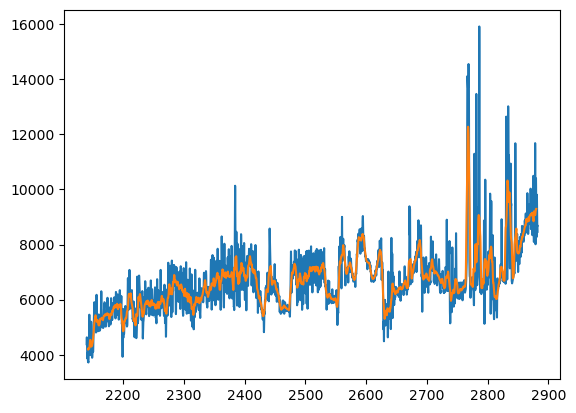

In [ ]:
mask = df_final.Well == df_final.Well.unique()[1]
plt.plot(df_final[mask].DEPTH, df_final[mask].IP)
plt.plot(df_final[mask].DEPTH, df_final[mask].IP_ups)

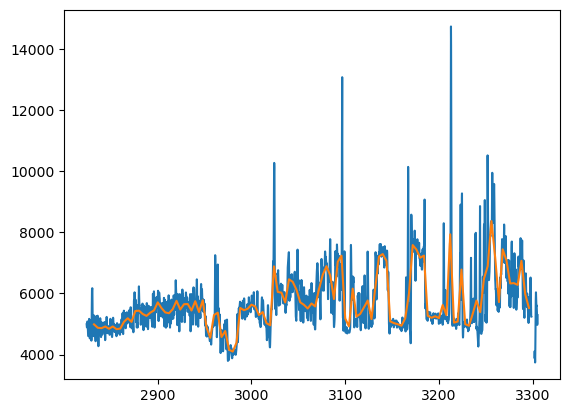

In [ ]:
mask = df_final.Well == df_final.Well.unique()[5]
plt.plot(df_final[mask].TWT, df_final[mask].IP)
plt.plot(time, log_well[5,:])

In [ ]:
log_well.shape

(16, 600)

Considere uma matriz com duas colunas, cada uma com o index da localização de cada poço em il e xl, respectivamento. Não são os valores absolutos.

In [ ]:
for well in df_final.Well.unique():
    print(well)

1-RJS-342-RJS
3-RJS-355-RJS
3-RJS-360A-RJS
3-RJS-510A-RJS
4-ABL-30A-RJS
4-RJS-367-RJS
4-RJS-477A-RJS
6-ABL-1-RJS
9-AB-67-RJS
9-AB-71-RJS
9-ABL-2-RJS
9-ABL-3B-RJS
9-ABL-5-RJS
9-ABL-6A-RJS
9-ABL-7-RJS
9-ABL-9D-RJS


In [ ]:
wells_names = [
'1-RJS-342',
'3-RJS-355',
'3-RJS-360A',
'3-RJS-510A',
'4-ABL-30A',
'4-RJS-367',
'4-RJS-477A',
'6-ABL-1',
'9-AB-67',
'9-AB-71',
'9-ABL-2',
'9-ABL-3B',
'9-ABL-5',
'9-ABL-6A',
'9-ABL-7',
 '9-ABL-9D']

#List pf wells positions in order
positions = [
[1118, 1410],
[1387, 1347],
[1220, 1703],
[940, 2376],
[1318, 2523],
[906, 2183],
[889, 1584],
[1304, 2088],
[1107, 1493],
[1054, 1500],
[1359, 1694],
[1017, 1778],
[1347, 1816],
[1466, 1823],
[1190, 1780],
[1071, 2031]]
positions = np.asarray(positions)


In [ ]:
positions.shape

(16, 2)

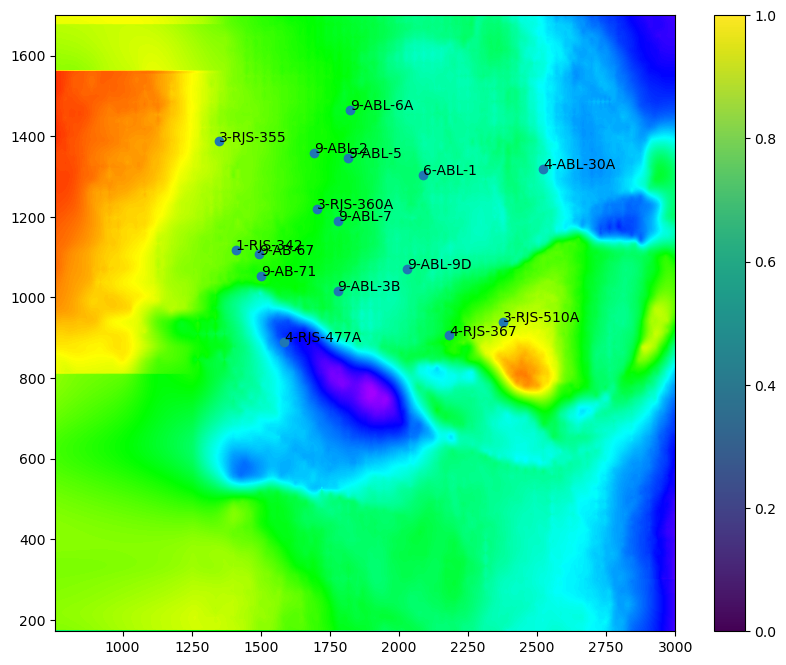

In [ ]:
plt.figure(figsize=(10,8))
plt.imshow(hrz_ma_grid, aspect='auto', cmap='gist_rainbow', extent=[xl.min(), xl.max(), il.min(), il.max()])
plt.scatter(positions[:,1], positions[:,0])
plt.ylim(il.min(),1700)
plt.xlim(xl.min(),3000)
for i in range(len(wells_names)):
    plt.text(positions[i,1], positions[i,0], wells_names[i])
plt.colorbar()

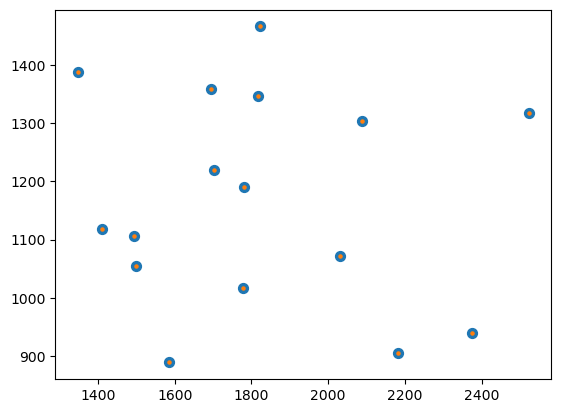

In [ ]:
plt.scatter(positions[:,1], positions[:,0], s=50)
plt.scatter(xl[mymodel.pos[1]], il[mymodel.pos[0]], s=5)

In [ ]:
relative_well_pos = positions.copy()
relative_well_pos[:,0] = relative_well_pos[:,0] - il.min()
relative_well_pos[:,1] = relative_well_pos[:,1] - xl.min()
relative_well_pos

array([[ 946,  654],
       [1215,  591],
       [1048,  947],
       [ 768, 1620],
       [1146, 1767],
       [ 734, 1427],
       [ 717,  828],
       [1132, 1332],
       [ 935,  737],
       [ 882,  744],
       [1187,  938],
       [ 845, 1022],
       [1175, 1060],
       [1294, 1067],
       [1018, 1024],
       [ 899, 1275]])

In [ ]:
relative_well_pos.shape

(16, 2)

In [ ]:
il.min(), xl.min()

(172, 756)

# Passo a passo

In [ ]:
il, xl, il.shape, xl.shape

(array([ 172,  173,  174, ..., 2337, 2338, 2339]),
 array([ 756,  757,  758, ..., 3505, 3506, 3507]),
 (2168,),
 (2752,))

## Inserir horizontes e construir RGT

## Cortar horizontes para ficar mais leve

In [ ]:
np.argmin(abs(il-1700))

1528

In [ ]:
il[1528]

1700

In [ ]:
np.argmin(abs(xl-3000))

2244

In [ ]:
xl[2244]

3000

In [ ]:
#hrz_mio_grid = hrz_mio_grid[:1528,:2244]
#hrz_base140_grid = hrz_base140_grid[:1528,:2244]
#hrz_ma_grid = hrz_ma_grid[:1528,:2244]

In [ ]:
hrz_ma_grid.shape

(2168, 2752)

## Constroi lista na ordem dos horizotnes

In [ ]:
# shift na base do sal pra cima (limite superior do modelo)
hrz_mio_grid_shift = hrz_mio_grid - 60

#shift na picarras pra baixo (limite inferior do modelo)
hrz_ma_grid_shift = hrz_ma_grid + 60

# superficies em ordem da rasa para a mais profunda
surfs = np.asarray([hrz_mio_grid_shift,
                   hrz_mio_grid,
                   hrz_base140_grid,
                   hrz_ma_grid,
                   hrz_ma_grid_shift])

surfs.shape

(5, 2168, 2752)

## Constroi modelo

In [ ]:
mymodel = BMTools()
mymodel.build_rgt(surfs, time, silence=False)
mymodel.rgt.shape

(2168, 2752, 600)

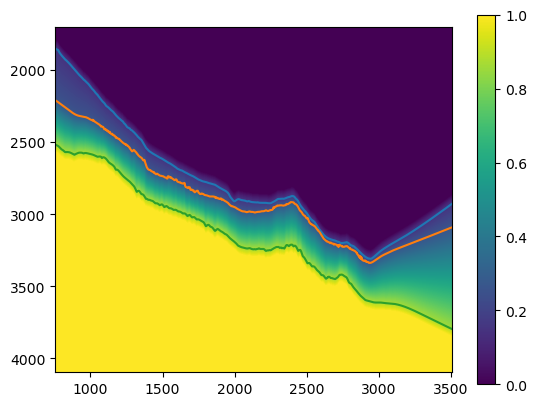

In [ ]:
plt.imshow(mymodel.rgt[813].T, extent=[xl.min(),xl.max(),time.max(),time.min()])
#plt.plot(xl[:2244], hrz_mio_grid[813].T)
#plt.plot(xl[:2244], hrz_base140_grid[813].T)
#plt.plot(xl[:2244], hrz_ma_grid[813].T)
plt.plot(xl, hrz_mio_grid[813].T)
plt.plot(xl, hrz_base140_grid[813].T)
plt.plot(xl, hrz_ma_grid[813].T)
plt.colorbar()

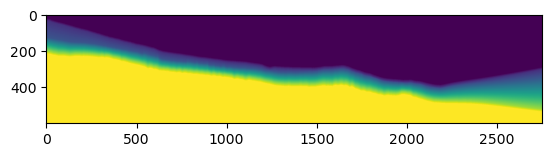

In [ ]:
plt.imshow(mymodel.rgt[813].T)

## Modelagem

Defina um variograma

In [ ]:
variogram = gs.Spherical(dim=2, len_scale=200, var=np.nanvar(log_well))

In [ ]:
angle = - np.pi / 8 # (-22.5º)
variogram = gs.Gaussian(dim=2, len_scale=[200, 100], angles=angle, var=np.nanvar(log_well))

Execute a interpolação (Krigagem Ordinaria)

In [ ]:
mymodel.interpol(variogram, log_well, relative_well_pos, fill_value=(3000,6000), silence=False, decimate=40, second_var = velocity_flat)

In [ ]:
mapa = np.zeros_like(hrz_base140_grid)
for i in range(hrz_base140_grid.shape[0]):
    for j in range(hrz_base140_grid.shape[1]):
        z = int((hrz_base140_grid[i,j]-1700)//4)
        #mapa[i,j] = mymodel.krig[i,j,z]
        mapa[i,j] = velocity[i,j,z]

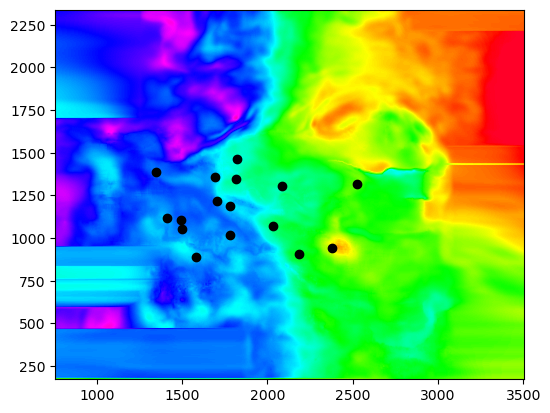

In [ ]:
plt.imshow(mapa[::-1,:], extent=[xl.min(), xl.max(), il.min(), il.max()], cmap='gist_rainbow') #, vmin=4500, vmax=7500
plt.scatter(positions[:,1], positions[:,0], color='k')

## Filtro passa-baixa

In [ ]:
mymodel.smooth_model(cut_hz=50, silence=False)

In [ ]:
plt.imshow(mymodel.model[813].T, aspect='auto', extent=[xl[0],xl[-1], 1, 0], cmap='gist_rainbow')

Visualização

In [ ]:
plt.imshow(mymodel.model[813].T, aspect='auto', extent=[xl[0],xl[-1], time[-1], time[0]], cmap='gist_rainbow')

In [ ]:
np.shape(mymodel.model[:,:,:])

In [ ]:
plt.figure(figsize=(10,8))
plt.imshow(mymodel.model[:,:,250], aspect='auto', cmap='gist_rainbow', extent=[xl.min(), 3000, il.min(), 1700])
plt.colorbar()
plt.scatter(positions[:,1], positions[:,0])
plt.ylim(il.min(),1700)
plt.xlim(xl.min(),3000)
for i in range(len(wells_names)):
    plt.text(positions[i,1], positions[i,0], wells_names[i])
#plt.colorbar()

# Exportar

Exemplo de função para exportar como SEG-Y, mas deve ser adaptada de acordo com a necessidade

In [ ]:
def export_as_sgy(asmatrix, ref_path, output_path):
    with segyio.open(segy_path) as src:
        spec = segyio.spec()
        spec.sorting = src.sorting
        spec.format = src.format
        spec.samples = src.samples
        spec.ilines = src.ilines
        spec.xlines = src.xlines

    with segyio.create(output_path, spec) as dst:
        data = asmatrix.copy()
        data = data.reshape((2060*1581,2201)) # reshape to (il*xl,nsamples)
        tr = 0
        for il_ in spec.ilines:
            for xl_ in spec.xlines:
                dst.header[tr] = {
                    segyio.su.iline  : il_,
                    segyio.su.xline  : xl_}

                dst.trace[tr] = data[tr]
                tr += 1

        dst.bin.update(tsort=segyio.TraceSortingFormat.INLINE_SORTING)

In [ ]:
cut_hz=50
fill_value=(2000,3500)
silence=False
decimate=2
skip_values=0

In [ ]:
mymodel.krig_flat = np.zeros_like(mymodel.rgt)
mymodel.krig = np.zeros_like(mymodel.rgt)
gridy = np.arange(mymodel.seismic_shape[0], dtype=np.float32)
gridx = np.arange(mymodel.seismic_shape[1], dtype=np.float32)
x, y = (mymodel.pos[1], mymodel.pos[0])
top, base = True, False
if decimate>=0:
    gridx_dec = gridx.copy()[::decimate]
    gridy_dec = gridy.copy()[::decimate]

for i in range(mymodel.seismic_shape[2]):
    dvals = mymodel.logs_flat[:, i]
    dvals[dvals==skip_values] = np.nan
    if np.sum(~np.isnan(dvals)) > 0:
        OK = gs.krige.Ordinary(variogram, (x, y), dvals)
        if decimate<=0:
            mymodel.krig_flat[:, :, i] = OK.structured([gridx, gridy])[0].T[::-1, :]
        else:
            krig_dec = OK.structured([gridx_dec, gridy_dec])[0]
            interpol = RectBivariateSpline(gridx_dec, gridy_dec, krig_dec)
            OK_structured = interpol(gridx, gridy)
            mymodel.krig_flat[:, :, i] = OK_structured.T[::-1, :]
        top, base = False, True
    elif top:
        mymodel.krig_flat[:, :, i] = fill_value[0]
    elif base:
        mymodel.krig_flat[:, :, i] = fill_value[1]
    if not silence:
        print(f"Kriging Index [{i}] ({((i + 1) / mymodel.seismic_shape[0]) * 100:.2f}%) done\r", end="")